# Загрузка Pandas и очистка данных

In [26]:
import pandas as pd
import numpy as np
import re
import ast
from datetime import datetime
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
def populate_none_values(df, column, new_vals):
    '''
    The method populates None values.

    Parameters:
    df (DataFrame).
    column (str): A name of a column.
    new_vals(Series or one common value): The new values for all None values.
    '''

    df.loc[df[column].isna(), column] = new_vals


def count_reviews(reviews):
    rs = re.findall("(?<=\[\[)(.*?)(?=\],)", reviews)
    rs_count = 0
    
    for r in rs:
        rs_count += len(r.split(', '))
        
    return np.uint16(rs_count)


def get_last_review_date(reviews):
    dates = re.findall("(\d{1,2}\/\d{1,2}\/\d{4})", reviews)
    if len(dates) > 1:
        dates = sorted([pd.to_datetime(date) for date in dates], reverse=True)
        return dates[0] - dates[len(dates) - 1]
    return None


def get_price_range_type(price_type_str, price_ranges):
    '''
    Transforms string price range to number
    
    Parameters:
    price_type_str(str): '$' or '$$ - $$$' or '$$$$'
    price_ranges(dictionary): {'$': 1, '$$ - $$$': 2, '$$$$': 3}
    '''
    return np.uint8(price_ranges.get(price_type_str, price_ranges['$$ - $$$']))


def iqr(df, column):
    perc_25 = df[column].quantile(0.25, interpolation="midpoint")
    perc_75 = df[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print('Q1: {}'.format(perc_25), 'Q3: {}'.format(perc_75), 'IQR: {}'.format(IQR),
          'Граница выбросов: [{a},{b}]'.format(a=perc_25 - 1.5*IQR, b=perc_75 + 1.5*IQR), sep='\n')

In [4]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('main_task.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


## Переименуем столбцы в удобный формат

In [6]:
df.rename(columns={'Restaurant_id': 'rest_id', 'City': 'city',
                     'Cuisine Style': 'cuisine_style', 'Ranking': 'ranking',
                     'Rating': 'rating', 'Price Range': 'price_range',
                    'Number of Reviews': 'number_of_rev', 'Reviews': 'reviews',
                    'URL_TA': 'url_ta', 'ID_TA': 'id_ta'}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
rest_id          40000 non-null object
city             40000 non-null object
cuisine_style    30717 non-null object
ranking          40000 non-null float64
rating           40000 non-null float64
price_range      26114 non-null object
number_of_rev    37457 non-null float64
reviews          40000 non-null object
url_ta           40000 non-null object
id_ta            40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


## Number of Reviews and Reviews

In [7]:
populate_none_values(df, 'number_of_rev', df[df['number_of_rev'].isna()]['reviews'].apply(count_reviews))

## Cuisine Style

In [8]:
df.loc[~df['cuisine_style'].isna(), 'cuisine_style'] = df.loc[~df['cuisine_style'].isna(), 'cuisine_style'].apply(
    lambda x: ast.literal_eval(x)
)

In [9]:
cuisines_counter = Counter()

for cuisines in df.loc[~df['cuisine_style'].isna(), 'cuisine_style']:
    for cuisine in cuisines:
        cuisines_counter[cuisine] += 1

cuisine_most_common = cuisines_counter.most_common(1)[0][0]
cuisine_most_common

'Vegetarian Friendly'

In [10]:
cuisine_prefix = 'cuisine_'

In [11]:
for cuisine in cuisines_counter.keys():
    df[f'{cuisine_prefix}{cuisine}'] = np.uint8(0)

In [12]:
for i, row in df.iterrows():
    if type(row['cuisine_style']) is not list or len(row['cuisine_style']) == 0:
        df.at[i, f'{cuisine_prefix}{cuisine_most_common}'] = np.uint8(1)
    else:
        for cuisine in row['cuisine_style']:
            df.at[i, f'{cuisine_prefix}{cuisine}'] = np.uint8(1)

## City

In [13]:
df = pd.get_dummies(df, columns=['city'], dummy_na=True)

## Price Range

In [14]:
df['price_range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64

In [15]:
price_ranges = { '$': 1, '$$ - $$$': 2, '$$$$': 3 }

In [16]:
df['price_range'] = df['price_range'].apply(lambda x: get_price_range_type(x, price_ranges))

## Training

In [17]:
df.loc[:, 'rating'] = df.loc[:, 'rating'].apply(lambda x: round(x))

In [18]:
df = df.drop(['id_ta', 'url_ta', 'rest_id', 'reviews', 'cuisine_style'], axis=1)

In [19]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 161 columns):
ranking                        float64
rating                         int64
price_range                    int64
number_of_rev                  float64
cuisine_European               uint8
cuisine_French                 uint8
cuisine_International          uint8
cuisine_Japanese               uint8
cuisine_Sushi                  uint8
cuisine_Asian                  uint8
cuisine_Grill                  uint8
cuisine_Vegetarian Friendly    uint8
cuisine_Vegan Options          uint8
cuisine_Gluten Free Options    uint8
cuisine_German                 uint8
cuisine_Central European       uint8
cuisine_Italian                uint8
cuisine_Pizza                  uint8
cuisine_Fast Food              uint8
cuisine_Mediterranean          uint8
cuisine_Spanish                uint8
cuisine_Healthy                uint8
cuisine_Cafe                   uint8
cuisine_Thai                   uint

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [20]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['rating'], axis = 1)
y = df['rating']

In [21]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [22]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# Создаём, обучаем и тестируем модель

In [23]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [24]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [25]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.14185699999999998


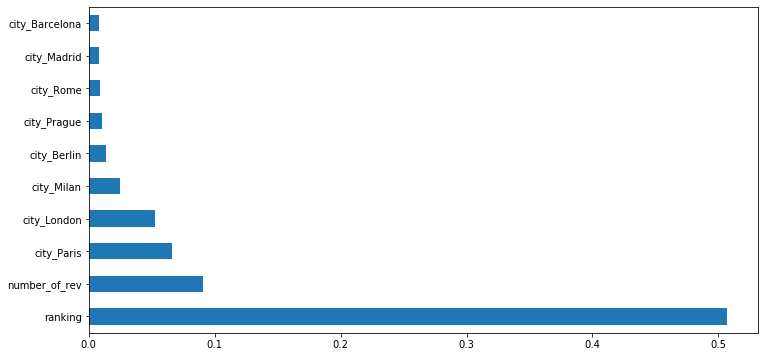

In [33]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (12,6)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')